In [4]:
from wind_dir_classifier import load_netcdf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [6]:
df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df['wd_100'] = np.arctan2(df['v100'], df['u100'])
# df['wd_10'] = df['wd_10'].where(df['wd_10']>0, df['wd_10']+2*np.pi)
# df['wd_100'] = df['wd_100'].where(df['wd_100']>0, df['wd_100']+2*np.pi)

In [7]:
bins = np.linspace(-np.pi, np.pi,9)
# labels = range(1,9)
labels = range(8)
df['wd_100_cat'] = pd.cut(df['wd_100'], bins=bins, include_lowest=True, labels=labels)

In [8]:
df['wd_100_cat'] = df['wd_100_cat'].cat.add_categories(8)
df['wd_100_cat'] = df['wd_100_cat'].where(df['windspeed_100']>2.5, 8)

<AxesSubplot: xlabel='wd_100_cat', ylabel='count'>

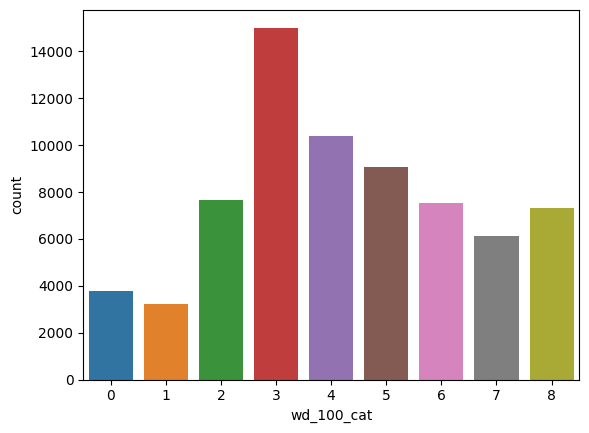

In [9]:
sns.countplot(x=df["wd_100_cat"])

In [10]:
df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

In [11]:
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100,wd_10,wd_100,wd_100_cat
0,275.332254,274.286849,101918.532777,1.398094e-06,0.0,2014-01-01 00:00:00,2.752297,6.002099,2.066113,1.804367,6
1,275.114286,274.076596,101898.790426,2.019469e-06,0.0,2014-01-01 01:00:00,2.651433,5.802979,2.062949,1.784102,6
2,274.602475,273.536258,101880.919674,3.650579e-06,0.0,2014-01-01 02:00:00,2.673724,5.867424,2.089295,1.817826,6
3,274.942533,273.854905,101837.691774,7.068143e-06,0.0,2014-01-01 03:00:00,2.851064,5.996153,2.084897,1.826003,6
4,275.290868,274.053719,101794.644996,1.141777e-05,0.0,2014-01-01 04:00:00,3.129658,6.222691,2.126541,1.884094,6
...,...,...,...,...,...,...,...,...,...,...,...
70123,284.349792,281.137893,101546.254844,5.248368e-06,0.0,2021-12-31 19:00:00,4.863692,9.516209,0.301300,0.219863,4
70124,284.497001,281.261584,101575.888525,-8.673617e-19,0.0,2021-12-31 20:00:00,5.021026,9.703558,0.229189,0.149879,4
70125,284.358537,281.442320,101573.573393,2.385622e-06,0.0,2021-12-31 21:00:00,5.312536,10.136289,0.142827,0.068730,4
70126,284.420482,281.305074,101574.499446,1.700153e-04,0.0,2021-12-31 22:00:00,6.211414,11.058230,0.007107,-0.045594,3


In [12]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

def to_supervised(data, n_input, n_out, y_index):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, y_index]) 
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y).reshape((len(y),1))

def data_prep(df, trainFrom, trainTo, testFrom, testTo, lookback, toFuture, y_featurename):

    train = df[df['Date Time']>='{}-01-01'.format(trainFrom)]
    train = train[train['Date Time']<'{}-01-01'.format(trainTo+1)]
    test = df[df['Date Time']>='{}-01-01'.format(testFrom)]
    test = test[test['Date Time']<'{}-01-01'.format(testTo+1)]

    train = datetimeToSignal(train)
    test = datetimeToSignal(test)

    y_index = train.columns.get_loc(y_featurename)

    values_train = train.values
    values_test = test.values

    y_train = values_train[:,y_index]
    y_test = values_test[:,y_index]

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values_train)
    # scaler_y = MinMaxScaler(feature_range=(0, 1))
    # scaler_y.fit(values_train[:,y_index].reshape(len(values_train),1))

    values_train = scaler.transform(values_train)
    values_test = scaler.transform(values_test)

    values_train[:,y_index] = y_train
    values_test[:,y_index] = y_test

    X_train, y_train = to_supervised(values_train, n_input=lookback, n_out=toFuture, y_index=y_index)
    X_test, y_test = to_supervised(values_test, n_input=lookback, n_out=toFuture, y_index=y_index)

    return X_train, y_train, X_test, y_test

In [13]:
# processing data for models training and evaluating
X_train, y_train, X_test, y_test = data_prep(df, trainFrom=2014, trainTo=2020, testFrom=2021, testTo=2021, lookback=24, toFuture=1, y_featurename='wd_100_cat')

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from tensorflow import keras

In [16]:
X_train.shape

(61343, 24, 14)

In [17]:
n_outputs = y_train.shape[1]

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])
dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 200)           3000      
                                                                 
 dropout (Dropout)           (None, 24, 200)           0         
                                                                 
 dense_1 (Dense)             (None, 24, 200)           40200     
                                                                 
 dropout_1 (Dropout)         (None, 24, 200)           0         
                                                                 
 dense_2 (Dense)             (None, 24, 200)           40200     
                                                                 
 dense_3 (Dense)             (None, 24, 9)             1809      
                                                                 
 reshape (Reshape)           (None, 216)               0

In [18]:
def compile_and_fit(model, X_train, y_train, X_test, y_test):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=4,
                                                   mode='min')

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], validation_data=(X_test,y_test), verbose=1)
    return history

In [19]:
history = compile_and_fit(dense, X_train, y_train, X_test, y_test)

Epoch 1/100
1917/1917 [==============================] - 27s 13ms/step - loss: 0.8267 - accuracy: 0.7152 - val_loss: 0.6319 - val_accuracy: 0.8135
Epoch 2/100
1917/1917 [==============================] - 24s 12ms/step - loss: 0.5971 - accuracy: 0.8157 - val_loss: 0.5938 - val_accuracy: 0.8110
Epoch 3/100
1917/1917 [==============================] - 24s 13ms/step - loss: 0.5487 - accuracy: 0.8262 - val_loss: 0.5469 - val_accuracy: 0.8252
Epoch 4/100
1917/1917 [==============================] - 21s 11ms/step - loss: 0.5255 - accuracy: 0.8300 - val_loss: 0.5342 - val_accuracy: 0.8211
Epoch 5/100
1917/1917 [==============================] - 22s 12ms/step - loss: 0.5078 - accuracy: 0.8315 - val_loss: 0.5145 - val_accuracy: 0.8313
Epoch 6/100
1917/1917 [==============================] - 22s 12ms/step - loss: 0.4937 - accuracy: 0.8347 - val_loss: 0.5270 - val_accuracy: 0.8279
Epoch 7/100
1917/1917 [==============================] - 22s 12ms/step - loss: 0.4852 - accuracy: 0.8359 - val_loss: 0

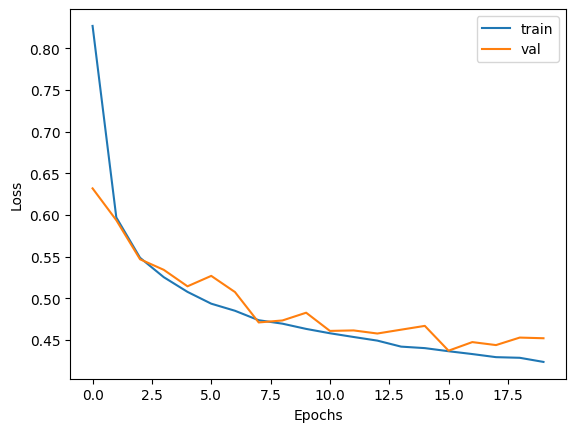

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

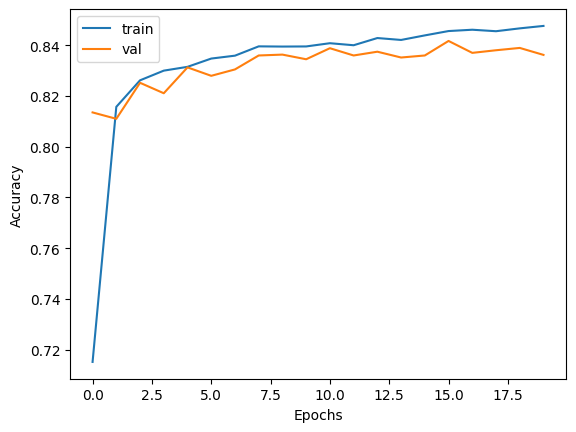

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
_, accuracy = dense.evaluate(X_test, y_test, batch_size=32, verbose=0)

In [23]:
accuracy

0.8361762762069702

273/273 [==============================] - 1s 5ms/step


<AxesSubplot: >

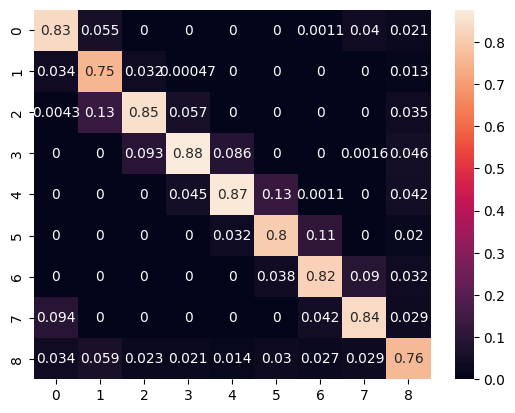

In [24]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = dense.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_for_cm = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_for_cm, y_prediction , normalize='pred')
sns.heatmap(cm, annot=True)

In [25]:
lstm = Sequential([
            LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.5),
            Dense(units=100, activation='relu'),
            Dense(n_outputs, activation='softmax'),
            # Reshape([n_outputs*24]),
            # Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46000     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 9)                 909       
                                                                 
Total params: 57,009
Trainable params: 57,009
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = compile_and_fit(lstm, X_train, y_train, X_test, y_test)

Epoch 1/100
1917/1917 [==============================] - 50s 25ms/step - loss: 0.8461 - accuracy: 0.7184 - val_loss: 0.6174 - val_accuracy: 0.8227
Epoch 2/100
1917/1917 [==============================] - 47s 24ms/step - loss: 0.6018 - accuracy: 0.8238 - val_loss: 0.5632 - val_accuracy: 0.8325
Epoch 3/100
1917/1917 [==============================] - 55s 29ms/step - loss: 0.5608 - accuracy: 0.8339 - val_loss: 0.5223 - val_accuracy: 0.8349
Epoch 4/100
1917/1917 [==============================] - 49s 25ms/step - loss: 0.5307 - accuracy: 0.8360 - val_loss: 0.5160 - val_accuracy: 0.8366
Epoch 5/100
1917/1917 [==============================] - 60s 32ms/step - loss: 0.5093 - accuracy: 0.8380 - val_loss: 0.4740 - val_accuracy: 0.8365
Epoch 6/100
1917/1917 [==============================] - 65s 34ms/step - loss: 0.4871 - accuracy: 0.8411 - val_loss: 0.4642 - val_accuracy: 0.8372
Epoch 7/100
1917/1917 [==============================] - 60s 31ms/step - loss: 0.4728 - accuracy: 0.8421 - val_loss: 0

In [27]:
_, accuracy = lstm.evaluate(X_test, y_test, batch_size=32, verbose=0)
accuracy

0.8507155179977417

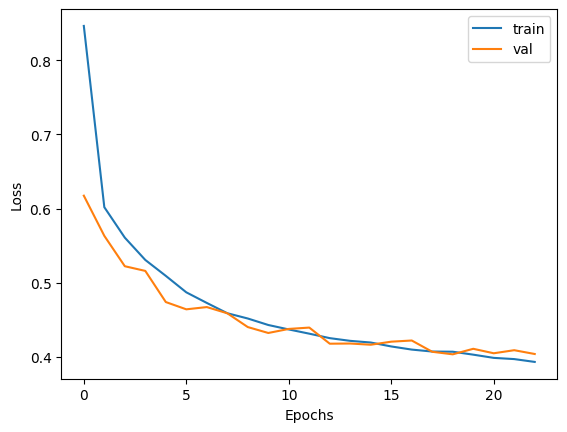

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

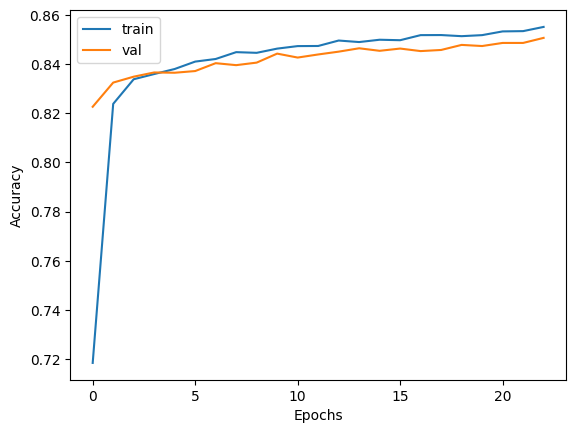

In [29]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

273/273 [==============================] - 4s 12ms/step


<AxesSubplot: >

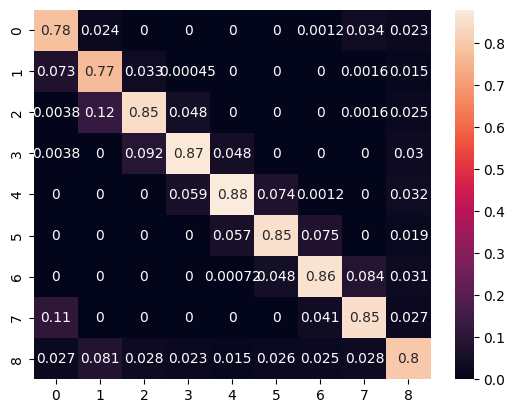

In [30]:
#Predict
y_prediction = lstm.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_for_cm = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_for_cm, y_prediction , normalize='pred')
sns.heatmap(cm, annot=True)

# CNN

In [150]:
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten

In [161]:
X_train.shape

(61343, 24, 14)

In [162]:
n_steps, n_length = 2, 12
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, X_test.shape[2]))

In [163]:
model2 = Sequential()
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,X_train.shape[-1])))
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model2.add(TimeDistributed(Dropout(0.5)))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(100))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(n_outputs, activation='softmax'))

In [164]:
history = compile_and_fit(model2, X_train, y_train, X_test, y_test)

Epoch 1/100
1917/1917 [==============================] - 13s 6ms/step - loss: 0.9637 - accuracy: 0.6653 - val_loss: 0.7786 - val_accuracy: 0.7475
Epoch 2/100
1917/1917 [==============================] - 11s 5ms/step - loss: 0.7149 - accuracy: 0.7745 - val_loss: 0.7166 - val_accuracy: 0.7705
Epoch 3/100
1917/1917 [==============================] - 11s 6ms/step - loss: 0.6603 - accuracy: 0.7916 - val_loss: 0.7832 - val_accuracy: 0.7127
Epoch 4/100
1917/1917 [==============================] - 11s 6ms/step - loss: 0.6289 - accuracy: 0.8005 - val_loss: 0.6462 - val_accuracy: 0.7910
Epoch 5/100
1917/1917 [==============================] - 11s 6ms/step - loss: 0.6059 - accuracy: 0.8051 - val_loss: 0.5875 - val_accuracy: 0.8179
Epoch 6/100
1917/1917 [==============================] - 11s 6ms/step - loss: 0.5855 - accuracy: 0.8094 - val_loss: 0.7509 - val_accuracy: 0.7086
Epoch 7/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.5703 - accuracy: 0.8114 - val_loss: 0.7103 -

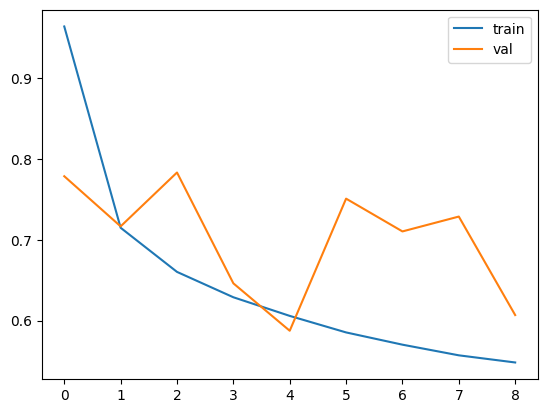

In [165]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Sprawdzic overfitting dla windspeed, sprobowac wprowadzic regularyzacje

# After 6 hours:

In [31]:
X_train, y_train, X_test, y_test = data_prep(df, trainFrom=2014, trainTo=2020, testFrom=2021, testTo=2021, lookback=24, toFuture=6, y_featurename='wd_100_cat')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [167]:
def compile_and_fit(model, X_train, y_train, X_test, y_test):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=4,
                                                   mode='min')

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], validation_data=(X_test,y_test), verbose=1)
    # history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test), verbose=1)
    return history

In [32]:
dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dropout(0.2),
            Dense(units=200, activation='relu'),
            Dense(n_outputs),
            Reshape([n_outputs*24]),
            Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])

history = compile_and_fit(dense, X_train, y_train, X_test, y_test)

Epoch 1/100
1917/1917 [==============================] - 23s 12ms/step - loss: 1.4159 - accuracy: 0.4574 - val_loss: 1.3010 - val_accuracy: 0.5076
Epoch 2/100
1917/1917 [==============================] - 25s 13ms/step - loss: 1.2624 - accuracy: 0.5163 - val_loss: 1.2945 - val_accuracy: 0.5103
Epoch 3/100
1917/1917 [==============================] - 26s 14ms/step - loss: 1.2226 - accuracy: 0.5308 - val_loss: 1.3112 - val_accuracy: 0.4875
Epoch 4/100
1917/1917 [==============================] - 29s 15ms/step - loss: 1.1987 - accuracy: 0.5378 - val_loss: 1.3059 - val_accuracy: 0.5007
Epoch 5/100
1917/1917 [==============================] - 22s 12ms/step - loss: 1.1821 - accuracy: 0.5442 - val_loss: 1.2410 - val_accuracy: 0.5202
Epoch 6/100
1917/1917 [==============================] - 25s 13ms/step - loss: 1.1682 - accuracy: 0.5485 - val_loss: 1.2433 - val_accuracy: 0.5226
Epoch 7/100
1917/1917 [==============================] - 28s 14ms/step - loss: 1.1543 - accuracy: 0.5544 - val_loss: 1

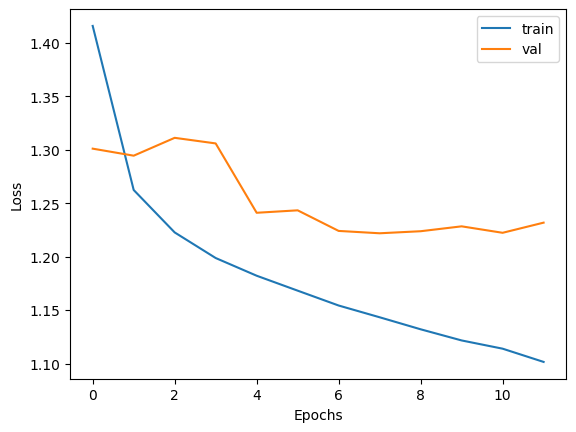

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

273/273 [==============================] - 1s 5ms/step


<AxesSubplot: >

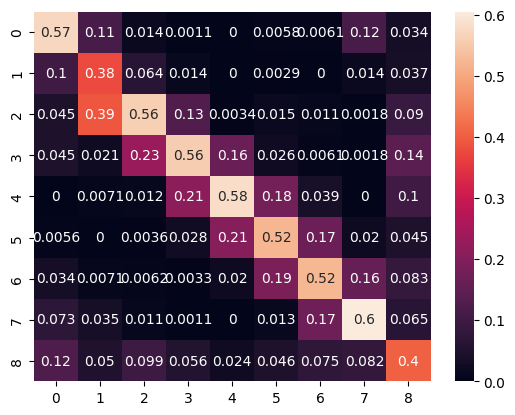

In [34]:
#Predict
y_prediction = dense.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_for_cm = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_for_cm, y_prediction , normalize='pred')
sns.heatmap(cm, annot=True)

In [35]:
_, accuracy = dense.evaluate(X_test, y_test, batch_size=32, verbose=0)
accuracy

0.5303550958633423

In [172]:
lstm = Sequential([
            LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.5),
            Dense(units=100, activation='relu'),
            Dense(n_outputs, activation='softmax'),
            # Reshape([n_outputs*24]),
            # Dense(n_outputs, activation='softmax'),
            # Reshape([1])
        ])
        
history = compile_and_fit(lstm, X_train, y_train, X_test, y_test)

Epoch 1/100
1917/1917 [==============================] - 72s 36ms/step - loss: 1.4470 - accuracy: 0.4607 - val_loss: 1.3334 - val_accuracy: 0.5087
Epoch 2/100
1917/1917 [==============================] - 78s 40ms/step - loss: 1.2925 - accuracy: 0.5161 - val_loss: 1.2687 - val_accuracy: 0.5190
Epoch 3/100
1917/1917 [==============================] - 27s 14ms/step - loss: 1.2474 - accuracy: 0.5280 - val_loss: 1.2415 - val_accuracy: 0.5348
Epoch 4/100
1917/1917 [==============================] - 27s 14ms/step - loss: 1.2176 - accuracy: 0.5377 - val_loss: 1.2250 - val_accuracy: 0.5377
Epoch 5/100
1917/1917 [==============================] - 27s 14ms/step - loss: 1.1928 - accuracy: 0.5437 - val_loss: 1.2142 - val_accuracy: 0.5414
Epoch 6/100
1917/1917 [==============================] - 27s 14ms/step - loss: 1.1757 - accuracy: 0.5510 - val_loss: 1.2020 - val_accuracy: 0.5332
Epoch 7/100
1917/1917 [==============================] - 27s 14ms/step - loss: 1.1628 - accuracy: 0.5558 - val_loss: 1

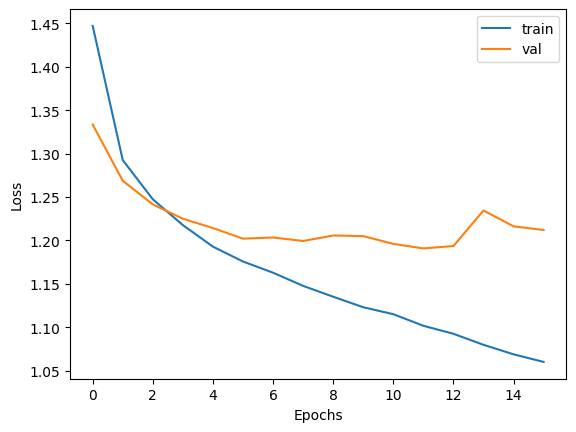

In [173]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

273/273 [==============================] - 2s 5ms/step


<AxesSubplot: >

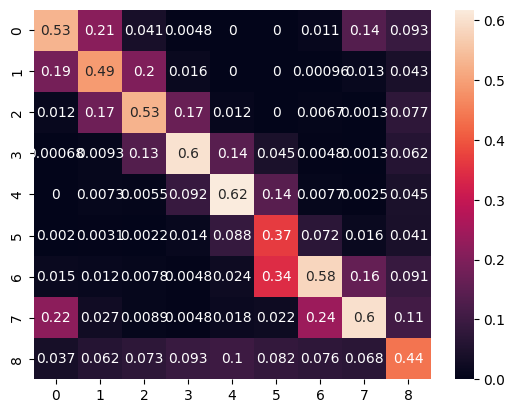

In [174]:
#Predict
y_prediction = lstm.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test_for_cm = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test_for_cm, y_prediction , normalize='pred')
sns.heatmap(cm, annot=True)

In [176]:
_, accuracy = lstm.evaluate(X_test, y_test, batch_size=32, verbose=0)
accuracy

0.5437571406364441